# Semestrální práce - Detekce kreditních podvodů

Vypracovali: Dalibor Illés, Max Nonfried

V této semestrální práci se pokusíme sestavit model pro odhalování podvodných transakcí u kreditních karet na základě informací o transakcích (typu čas, lokace, atd). Pracujeme s daty z webové stránky https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023. Data obsahují informace o transakcích z kreditních karet, včetně výše částky u dané transakce, a cílovou proměnnou s názvem "Class" s hodnotami "1","0", které indikují, zda je transakce podvodná či ne.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import matplotlib

In [2]:
# Import dat
df = pd.read_csv('creditcard_2023.csv')

## Základní informace o datasetu

In [3]:
df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


Popis sloupců:<br>
id - unikátní identifikátor transakce<br>
V1-V28 - anonymizované údaje ohledně času, místa,...<br>
Amount - částka, která byla v transakci odeslána<br>
Class - binární operátor jestli byla transakce podvodná (1) nebo nebyla (0)<br><br>

Vypíšeme si informace o sloupcích, dimenze datasetu a zdali obsahuje nějaké duplicitní, nebo NaN hodnoty.

In [4]:
# Info
print(df.info())
print("\nShape: ", df.shape)
print("Počet duplicitních záznamů: ", df.duplicated().sum())
print("Počet NaN hodnot:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

Dataset neobsahuje žádné duplicitní ani NaN hodnoty.
Pro lepší představu o datasetu si vykraslíme graf s počtem podvodných a nepodvodných transakcí.

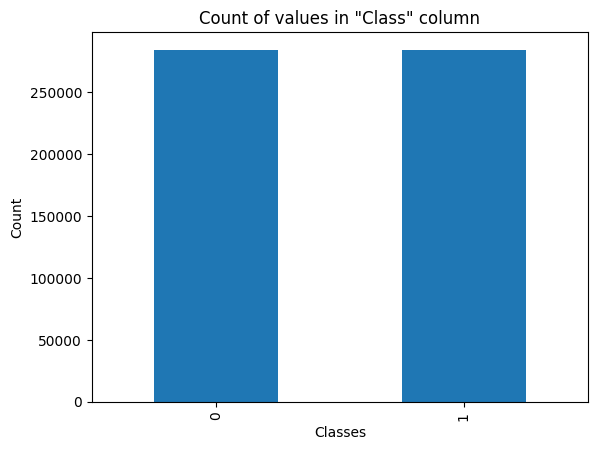

In [5]:
df['Class'].value_counts().plot(kind='bar')
plt.title('Count of values in "Class" column')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

Na grafu můžeme vidět, že počet podvodných a nepodvodných transakcí je vyrovnaný.

## Úprava dat
Rozdělíme data na trénovací a testovací. Jako target použijeme sloupec Class. Features budou všechny sloupce kromě id a Class. K testování použijeme 20 % záznamů.

In [6]:
X = df.drop(['id', 'Class'], axis=1) # Vynecháme sloupce "id" a "Class"
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Korelační matice

<Axes: >

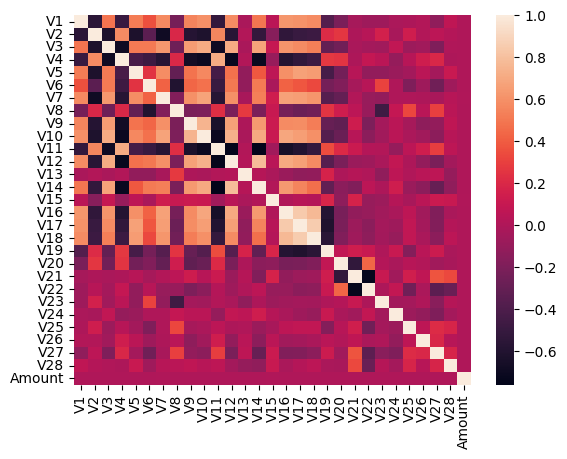

In [7]:
corr = X_train.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

Na grafu vidíme, že mezi sloupci v rozmezí V1-V18 je větší korelace, než u zbytku datasetu. Konkrétně největší korelace je mezi sloupci V16 a V17, V17 a V18. Z trénovacích a testovacích dat odstraníme sloupce, které mají korelaci větší než 0.8.

In [8]:
threshold = 0.8

# Matici převedeme pouze na kladné hodnoty
corr = corr.abs()

# Vybereme horní "trojúhelník" matice
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Zjistíme, které sloupce mají korelaci vyšší než threshold.
col_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Odstraníme sloupce z trénovaích i testovacíh dat
X_train.drop(col_to_drop, axis=1, inplace=True)
X_test.drop(col_to_drop, axis=1, inplace=True)

print("Odstranili jsme sloupce: ", col_to_drop)

Odstranili jsme sloupce:  ['V17', 'V18']


## DecisionTreeClassifier

Pomocí DecisionTreeClassifieru vytvoříme předpovědi pro sloupec Class.

In [9]:
decision_tree = DecisionTreeClassifier(max_depth = 5)
model_tree = decision_tree.fit(X_train, y_train)
predictions_tree = model_tree.predict(X_test)

In [10]:
score = accuracy_score(y_test, predictions_tree)
print("Úspěšnost rozhodovacího stromu: ", score)

Úspěšnost rozhodovacího stromu:  0.9602817297715562


[Text(0.4419642857142857, 0.9166666666666666, 'V14 <= 0.008\ngini = 0.5\nsamples = 454904\nvalue = [227565, 227339]\nclass = Not fraud'),
 Text(0.16964285714285715, 0.75, 'V4 <= -0.746\ngini = 0.054\nsamples = 207820\nvalue = [5773, 202047]\nclass = Fraud'),
 Text(0.05357142857142857, 0.5833333333333334, 'V10 <= -0.447\ngini = 0.275\nsamples = 2510\nvalue = [2097, 413]\nclass = Not fraud'),
 Text(0.03571428571428571, 0.4166666666666667, 'gini = 0.0\nsamples = 322\nvalue = [0, 322]\nclass = Fraud'),
 Text(0.07142857142857142, 0.4166666666666667, 'V4 <= -0.838\ngini = 0.08\nsamples = 2188\nvalue = [2097, 91]\nclass = Not fraud'),
 Text(0.03571428571428571, 0.25, 'V7 <= 0.121\ngini = 0.017\nsamples = 1813\nvalue = [1797, 16]\nclass = Not fraud'),
 Text(0.017857142857142856, 0.08333333333333333, 'gini = 0.219\nsamples = 128\nvalue = [112, 16]\nclass = Not fraud'),
 Text(0.05357142857142857, 0.08333333333333333, 'gini = 0.0\nsamples = 1685\nvalue = [1685, 0]\nclass = Not fraud'),
 Text(0.10

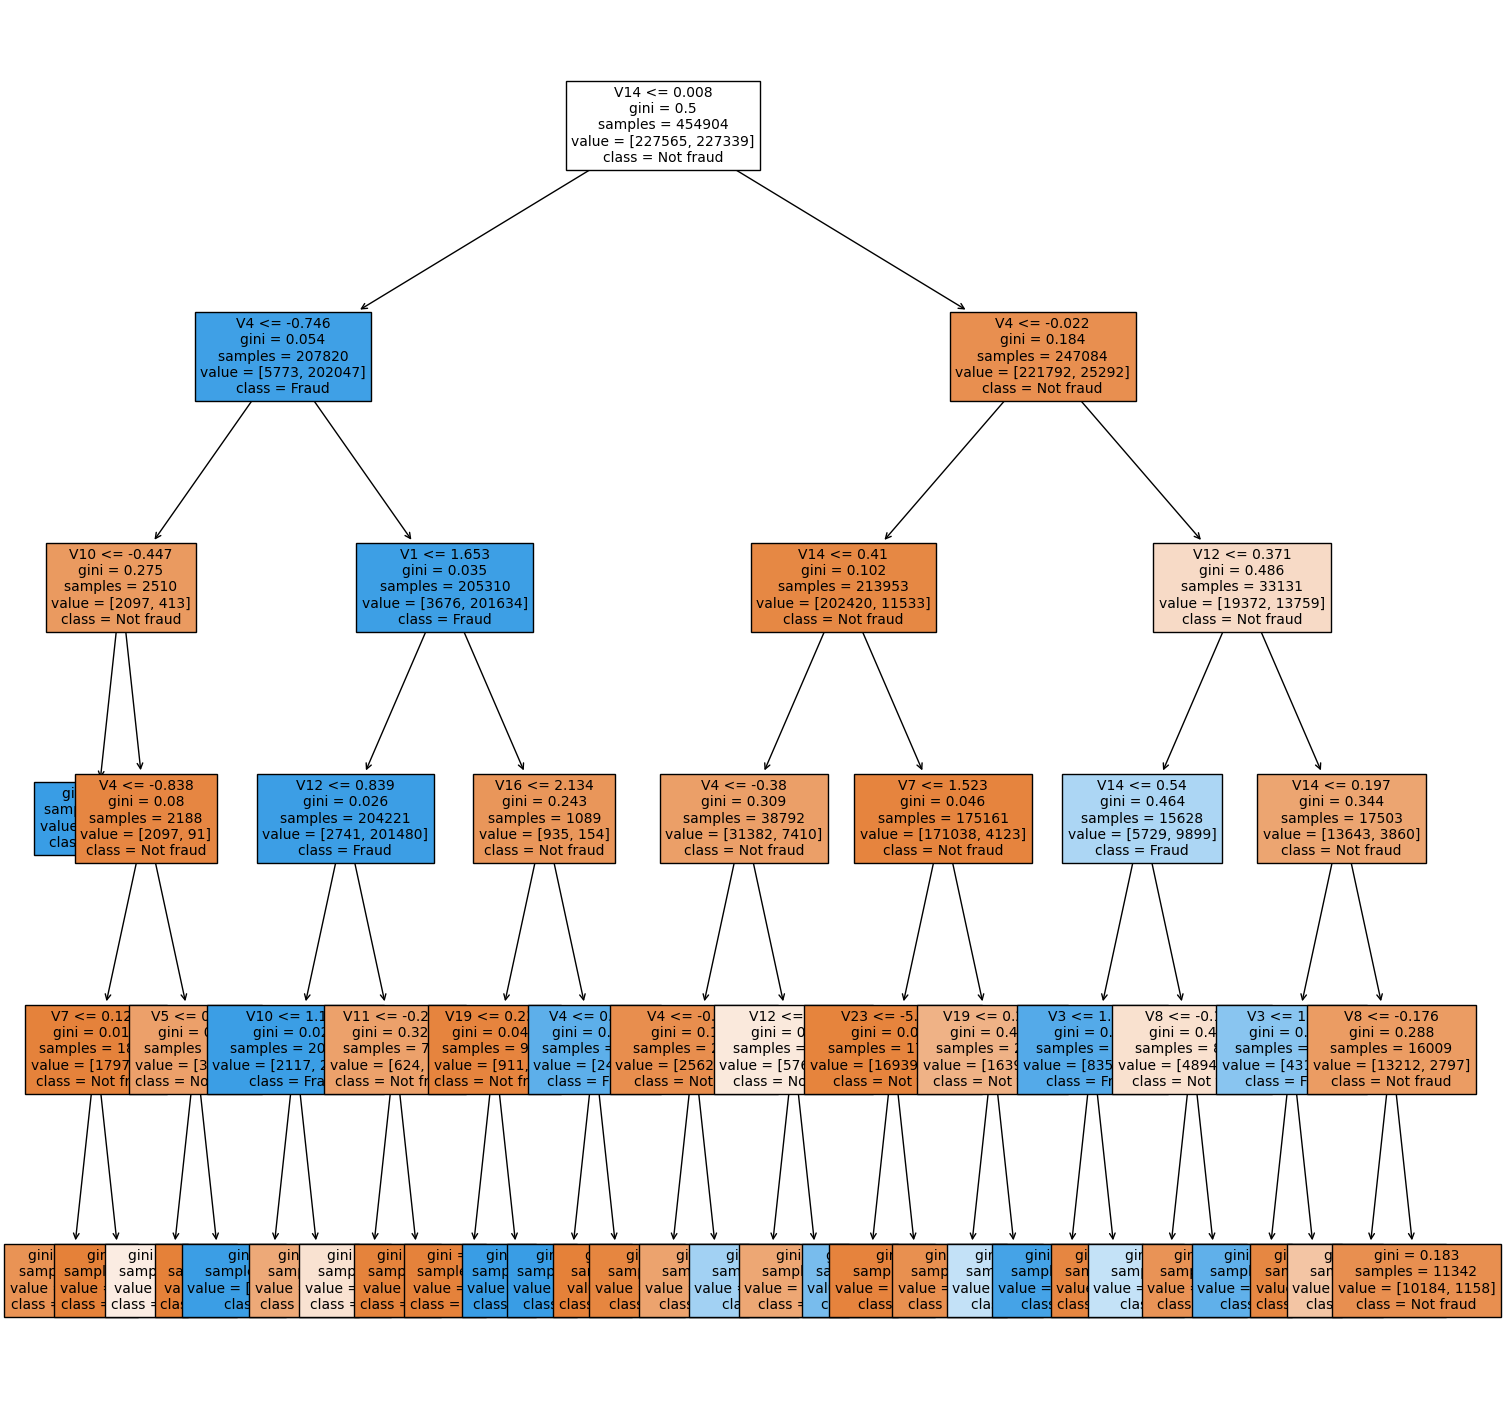

In [11]:
plt.figure(figsize=(18,18))
plot_tree(model_tree, feature_names = list(X_train.columns), class_names=["Not fraud","Fraud"], filled = True,fontsize=10)  

In [12]:
report_tree = classification_report(y_test, predictions_tree)
print(report_tree)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     56750
           1       0.97      0.95      0.96     56976

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726



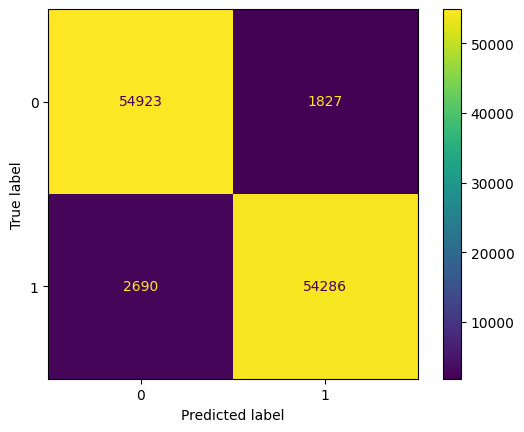

In [13]:
ConfusionMatrixDisplay.from_estimator(model_tree, X_test, y_test)

Úspěšnost rozhodovacího stromu je 96,02 %. 

Rozhodnutí 0 (nepodvodná transakce) jsme na testovacích datech rozhodli u 56750 transakcí, z toho v 54923 případech správně. Relativně to odpovídá 95 % případů.<br>
Rozhodnutí 1 (podvodná transakce) jsme určili u 56976 tasnakcí, z toho 54286 správně (relativně 97 %).

DecisionTreeClassifier má o 2 % lepší úspěšnost v předpovídání podvo

### ROC křivka

Skóre ROC křivky:  0.9834443227970167


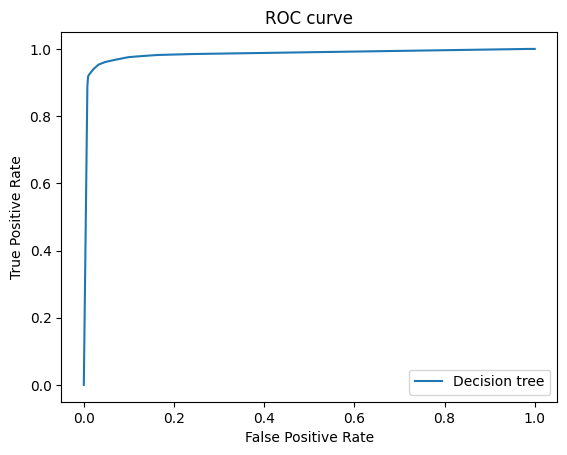

In [14]:
# Necháme pouze druhý sloupec, tedy, že transakce byla podvodná.
prob_pred_tree = model_tree.predict_proba(X_test)[:,1]

fpr, tpr, _thresholds  = roc_curve(y_test, prob_pred_tree, pos_label=model_tree.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name="Decision tree").plot()
plt.title("ROC curve")
print("Skóre ROC křivky: ", roc_auc_score(y_test, prob_pred_tree))

### Nejvýznamnější proměnná

In [15]:
features = list(X_train.columns)
importances = dict((features[i], model_tree.feature_importances_[i]) for i in range(len(features)))
sort_importances = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True))
sort_importances

{'V14': 0.879903326580075,
 'V4': 0.0665262357795376,
 'V12': 0.023712273502553022,
 'V1': 0.007783058168393543,
 'V8': 0.006183991144505782,
 'V10': 0.005168117839399039,
 'V3': 0.004921720356832021,
 'V7': 0.0015606587315943703,
 'V23': 0.0014033290549969103,
 'V19': 0.001398300756712271,
 'V16': 0.0009003181223268587,
 'V11': 0.00034242907113007486,
 'V5': 0.00019624089194360765,
 'V2': 0.0,
 'V6': 0.0,
 'V9': 0.0,
 'V13': 0.0,
 'V15': 0.0,
 'V20': 0.0,
 'V21': 0.0,
 'V22': 0.0,
 'V24': 0.0,
 'V25': 0.0,
 'V26': 0.0,
 'V27': 0.0,
 'V28': 0.0,
 'Amount': 0.0}

Největší dopad na tvorbu predikce u rozhodovacího stromu má proměnná V14, a to velmi výrazný - z 87 %. Druhá proměnná s největším dopadem je V4 s přibližně 6 %. Je zajímavé, že zhruba polovina proměnných nebyla pro tvorbu predikce podstatná.

## Metaparameter tuning

In [16]:
parametergrid = {
    "criterion" : ["gini"],
    "max_depth":range(1,6),    
}

model_tree_tun = GridSearchCV(DecisionTreeClassifier(random_state=42), parametergrid)
model_tree_tun.fit(X_train, y_train)

print("Nejlepší model: ", model_tree_tun.best_estimator_)
print("Nejlepší parametry: ", model_tree_tun.best_params_)
print("Nejlepší skóre: ", model_tree_tun.best_score_ )

Nejlepší model:  DecisionTreeClassifier(max_depth=5, random_state=42)
Nejlepší parametry:  {'criterion': 'gini', 'max_depth': 5}
Nejlepší skóre:  0.9602113847511358


Z důvodu časové náročnosti procesu ladění parametrů jsme zvolili pouze jeden parametr pro kritérium a poměrně malý číselný rozsah pro hloubku stromu.

## Logistická regrese

Nyní pro vytvoření předpovědi použijeme logistickou regresi.

In [17]:
model_lr = LogisticRegression(max_iter=500, random_state=42)
model_lr.fit(X_train, y_train)
predictions_lr = model_lr.predict(X_test)
print("Úšpěšnost predikce vytvořené logistickou regresí je: ", accuracy_score(y_test, predictions_lr))

Úšpěšnost predikce vytvořené logistickou regresí je:  0.9488419534671051


In [18]:
report_lr = classification_report(y_test, predictions_lr)
print(report_lr)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     56750
           1       0.98      0.92      0.95     56976

    accuracy                           0.95    113726
   macro avg       0.95      0.95      0.95    113726
weighted avg       0.95      0.95      0.95    113726



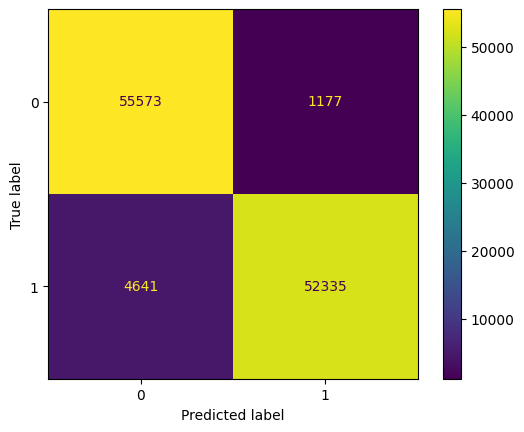

In [19]:
ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test)

Úspěšnost logistické regrese je 94,84 %.

Rozhodnutí 0 (nepodvodná transakce) jsme na testovacích datech rozhodli u 56750 transakcí, z toho v 55573 případech správně. Relativně to odpovídá 92 % případů.<br>
Rozhodnutí 1 (podvodná transakce) jsme určili u 56976 tasnakcí, z toho 52335 správně (relativně 98 %).

Logistická regrese má o 6 % lepší úspěšnost v předpovídání podvodných transakcí.

### Nejvýznamnější proměnná

In [20]:
importances = dict((features[i], np.exp(model_lr.coef_)[0][i]) for i in range(len(features)))
sort_importances = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True))
sort_importances

{'V4': 4.072587210256963,
 'V11': 2.311516908471089,
 'V2': 1.4325656401148135,
 'V25': 1.2863814085694307,
 'V5': 1.2427796154423116,
 'V27': 1.159506440043475,
 'V21': 1.1384973252105453,
 'V28': 1.132430499267056,
 'V16': 1.052983379596387,
 'Amount': 1.0000863104912259,
 'V20': 0.9553763701827804,
 'V22': 0.918055816031662,
 'V23': 0.9140576465089302,
 'V8': 0.9113664042965974,
 'V26': 0.8484038889623301,
 'V7': 0.8192759124076696,
 'V15': 0.813732302695883,
 'V13': 0.7401198536620043,
 'V24': 0.7332674242311981,
 'V1': 0.7219300013691842,
 'V6': 0.6748173296876382,
 'V9': 0.6316546211023862,
 'V19': 0.5589631768190664,
 'V10': 0.54002878659597,
 'V3': 0.41946047122090113,
 'V12': 0.36166633079398586,
 'V14': 0.2776880659285737}

Narozdíl od rozhodovacího stromu, u logistické regrese to byla proměnná V4, která má největší dopad na tvorbu predikce. Proměnná V14, která byla první u rozhodovací stromu má u logistické regrese nejmenší dopad na předpověď.

## Random forest

A jako poslední použijeme pro predikování náhodný les.

In [21]:
model_forest = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
model_forest.fit(X_train, y_train)
predictions_rf = model_forest.predict(X_test) 
print("Úšpěšnost predikce vytvořené náhodným lesem je: ", accuracy_score(y_test, predictions_rf))

Úšpěšnost predikce vytvořené náhodným lesem je:  0.9554807168105798


In [22]:
report_lr = classification_report(y_test, predictions_rf)
print(report_lr)

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56750
           1       0.99      0.92      0.95     56976

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726



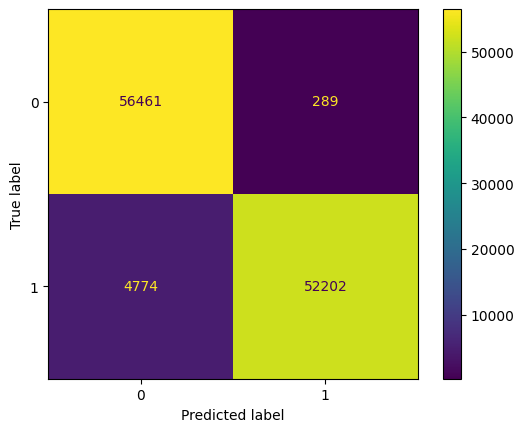

In [23]:
ConfusionMatrixDisplay.from_estimator(model_forest, X_test, y_test)

Úspěšnost náhodného lesa je 95,54 %.

Rozhodnutí 0 (nepodvodná transakce) jsme na testovacích datech rozhodli u 56750 transakcí, z toho v 56461 případech správně. Relativně to odpovídá 92 % případů.<br>
Rozhodnutí 1 (podvodná transakce) jsme určili u 56976 tasnakcí, z toho 52202 správně (relativně 99 %).

Náhodný les má o 7 % lepší úspěšnost v předpovídání podvodných transakcí.

### Nejvýznamnější proměnná

In [24]:
importances = dict((features[i], model_forest.feature_importances_[i]) for i in range(len(features)))
sort_importances = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True))
sort_importances

{'V14': 0.2500075511183572,
 'V10': 0.24435291407889978,
 'V4': 0.12130564660511681,
 'V3': 0.09567156227212742,
 'V12': 0.09395230731608857,
 'V16': 0.05017841182583831,
 'V11': 0.034329428260620604,
 'V7': 0.03117845108862762,
 'V21': 0.024398966776948496,
 'V2': 0.018074511266706412,
 'V27': 0.014260617541483922,
 'V8': 0.004756849323333226,
 'V9': 0.00406092955004658,
 'V1': 0.002157299266871646,
 'V5': 0.0017499231590950343,
 'V20': 0.0017480951704056725,
 'V19': 0.0016837510520104077,
 'V6': 0.0016449160756321914,
 'V28': 0.0010669006466681402,
 'V13': 0.0007900263094415155,
 'V23': 0.0005810377671387582,
 'V25': 0.0005263900164448968,
 'V15': 0.0004955611509476589,
 'V26': 0.0004907029497369648,
 'V22': 0.00041370781480459985,
 'V24': 0.00012314994859761633,
 'Amount': 3.9164800994527704e-07}

U predikce vytvořené náhodným lese se vliv proměnných rozložil do vícero položek. Největší vliv měly proměnné V14, V10, V4 a V12, které všechny mají hodnoty větší než 0,1. Ostatní proměnné mají hodnoty menší než 0,1.

## Závěr

Po zpracování dat jsme rozhodli použít tyto tři metody, pomocí Random Forest jsme se dostali na úšpěšnost predikce 0.955, při použití LogisticRegression jsme získali 0.948 a za použití DecisionTreeClassifier dokonce na 0.960. Tedy dokážeme s 96,02% přesností správně určit legitimitu transakce.